# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# a cohort name (it could be something like UK_BIOBANK, etc)
COHORT_NAME = None

# reference panel such as 1000G or GTEX_V8
REFERENCE_PANEL = None

# predictions models such as MASHR or ELASTIC_NET
EQTL_MODEL = None

In [4]:
# Parameters
COHORT_NAME = "1000G_EUR"
REFERENCE_PANEL = "GTEX_V8"
EQTL_MODEL = "MASHR"


In [5]:
assert COHORT_NAME is not None and len(COHORT_NAME) > 0, "A cohort name must be given"

COHORT_NAME = COHORT_NAME.lower()
display(f"Cohort name: {COHORT_NAME}")

'Cohort name: 1000g_eur'

In [6]:
assert (
    REFERENCE_PANEL is not None and len(REFERENCE_PANEL) > 0
), "A reference panel must be given"

display(f"Reference panel: {REFERENCE_PANEL}")

'Reference panel: GTEX_V8'

In [7]:
assert (
    EQTL_MODEL is not None and len(EQTL_MODEL) > 0
), "A prediction/eQTL model must be given"

display(f"eQTL model: {EQTL_MODEL})")

'eQTL model: MASHR)'

In [8]:
OUTPUT_DIR_BASE = (
    conf.RESULTS["GLS"]
    / "gene_corrs"
    / "cohorts"
    / COHORT_NAME
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr'

In [9]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr"

display(f"Gene correlations input dir: {INPUT_DIR}")
assert INPUT_DIR.exists()

'Gene correlations input dir: /project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr'

# Load data

## Gene correlations

In [10]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [11]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [12]:
len(all_gene_corr_files)

22

In [13]:
all_gene_corr_files

[PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr1.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr2.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr3.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr4.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr5.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr6.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/by_chr/gene_corrs-chr7.pkl'),
 PosixPath('/

In [14]:
assert len(all_gene_corr_files) == 22

## Get common genes

In [15]:
gene_ids = set()
for f in all_gene_corr_files:
    chr_genes = pd.read_pickle(f).index.tolist()
    gene_ids.update(chr_genes)

In [16]:
display(len(gene_ids))

6442

In [17]:
sorted(list(gene_ids))[:5]

['ENSG00000000419',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001084',
 'ENSG00000001167']

## Gene info

In [18]:
genes_info = pd.read_pickle(OUTPUT_DIR_BASE / "genes_info.pkl")

In [19]:
genes_info.shape

(6444, 7)

In [20]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,HEYL,ENSG00000163909,1,1p34.2,39623435.0,39639643.0,16208.0
1,CYP24A1,ENSG00000019186,20,20q13.2,54153446.0,54173986.0,20540.0
2,ITGB4,ENSG00000132470,17,17q25.1,75721328.0,75757818.0,36490.0
3,SPINT1,ENSG00000166145,15,15q15.1,40844018.0,40858207.0,14189.0
4,PCSK6,ENSG00000140479,15,15q26.3,101297142.0,101525202.0,228060.0


In [21]:
# keep genes in correlation matrices only
genes_info = genes_info[genes_info["id"].isin(gene_ids)]

In [22]:
genes_info.shape

(6442, 7)

In [23]:
assert not genes_info.isna().any().any()

In [24]:
genes_info.dtypes

name               object
id                 object
chr                object
band               object
start_position    float64
end_position      float64
gene_length       float64
dtype: object

In [25]:
genes_info["chr"] = genes_info["chr"].apply(pd.to_numeric, downcast="integer")
genes_info["start_position"] = genes_info["start_position"].astype(int)
genes_info["end_position"] = genes_info["end_position"].astype(int)
genes_info["gene_length"] = genes_info["gene_length"].astype(int)

In [26]:
genes_info.dtypes

name              object
id                object
chr                int64
band              object
start_position     int64
end_position       int64
gene_length        int64
dtype: object

In [27]:
assert not genes_info.isna().any(None)

In [28]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,HEYL,ENSG00000163909,1,1p34.2,39623435,39639643,16208
1,CYP24A1,ENSG00000019186,20,20q13.2,54153446,54173986,20540
2,ITGB4,ENSG00000132470,17,17q25.1,75721328,75757818,36490
3,SPINT1,ENSG00000166145,15,15q15.1,40844018,40858207,14189
4,PCSK6,ENSG00000140479,15,15q26.3,101297142,101525202,228060


# Create full correlation matrix

In [29]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [30]:
genes_info

,name,id,chr,band,start_position,end_position,gene_length
5467,NOC2L,ENSG00000188976,1,1p36.33,944203,959309,15106
4418,HES4,ENSG00000188290,1,1p36.33,998962,1000172,1210
3925,ISG15,ENSG00000187608,1,1p36.33,1001138,1014540,13402
3937,AGRN,ENSG00000188157,1,1p36.33,1020120,1056118,35998
4181,TNFRSF18,ENSG00000186891,1,1p36.33,1203508,1206592,3084
...,...,...,...,...,...,...,...
4386,CPT1B,ENSG00000205560,22,22q13.33,50568861,50578465,9604
5567,CHKB,ENSG00000100288,22,22q13.33,50578949,50601455,22506
3320,MAPK8IP2,ENSG00000008735,22,22q13.33,50600793,50613981,13188
3680,ARSA,ENSG00000100299,22,22q13.33,50622754,50628173,5419


In [31]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [32]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [33]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True)

    corr_data = pd.read_pickle(chr_corr_file)
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

gene_corrs-chr1.pkl
gene_corrs-chr2.pkl
gene_corrs-chr3.pkl
gene_corrs-chr4.pkl
gene_corrs-chr5.pkl
gene_corrs-chr6.pkl
gene_corrs-chr7.pkl
gene_corrs-chr8.pkl
gene_corrs-chr9.pkl
gene_corrs-chr10.pkl
gene_corrs-chr11.pkl
gene_corrs-chr12.pkl
gene_corrs-chr13.pkl
gene_corrs-chr14.pkl
gene_corrs-chr15.pkl
gene_corrs-chr16.pkl
gene_corrs-chr17.pkl
gene_corrs-chr18.pkl
gene_corrs-chr19.pkl
gene_corrs-chr20.pkl
gene_corrs-chr21.pkl
gene_corrs-chr22.pkl


In [34]:
full_corr_matrix.shape

(6442, 6442)

In [35]:
full_corr_matrix.head()

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188290,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000187608,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188157,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000186891,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

True

## Some checks

In [37]:
assert not full_corr_matrix.isna().any(None)
assert not np.isinf(full_corr_matrix.to_numpy()).any()
assert not np.iscomplex(full_corr_matrix.to_numpy()).any()

In [38]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
assert _min_val >= 0.0

0.0

In [39]:
_max_val = full_corr_matrix.max().max()  # this will capture the 1.0 in the diagonal
display(_max_val)
assert _max_val <= 1.00

1.0

## Save original matrix

### With gene symbols

In [40]:
output_file = OUTPUT_DIR_BASE / "gene_corrs-symbols-orig.pkl"
display(output_file)

PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/gene_corrs-symbols-orig.pkl')

In [41]:
gene_corrs = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [42]:
assert not gene_corrs.isna().any(None)
assert not np.isinf(gene_corrs.to_numpy()).any()
assert not np.iscomplex(gene_corrs.to_numpy()).any()

In [43]:
assert gene_corrs.index.is_unique
assert gene_corrs.columns.is_unique

In [44]:
gene_corrs.shape

(6442, 6442)

In [45]:
gene_corrs.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
gene_corrs.to_pickle(output_file)

In [47]:
del gene_corrs

# Positive definiteness

In [48]:
# print negative eigenvalues
eigs = np.linalg.eigvals(full_corr_matrix.to_numpy())
display(len(eigs[eigs < 0]))
display(eigs[eigs < 0])

2

array([-1.15916467e-08, -5.54504096e-17])

In [49]:
CHOL_DECOMPOSITION_FAILED = None

try:
    chol_mat = np.linalg.cholesky(full_corr_matrix.to_numpy())
    cov_inv = np.linalg.inv(chol_mat)
    print("Works!")
    CHOL_DECOMPOSITION_FAILED = False
except Exception as e:
    print(f"Cholesky decomposition failed: {str(e)}")
    CHOL_DECOMPOSITION_FAILED = True

Cholesky decomposition failed: Matrix is not positive definite


## Adjust

In [50]:
%load_ext rpy2.ipython

In [51]:
%%R
# taken and adapted from https://www.r-bloggers.com/2013/08/correcting-a-pseudo-correlation-matrix-to-be-positive-semidefinite/
CorrectCM <- function(CM, p = 0) {
  n <- dim(CM)[1L]
  E <- eigen(CM)
  CM1 <- E$vectors %*% tcrossprod(diag(pmax(E$values, p), n), E$vectors)
  Balance <- diag(1 / sqrt(diag(CM1)))
  CM2 <- Balance %*% CM1 %*% Balance
  return(CM2)
}

In [52]:
if CHOL_DECOMPOSITION_FAILED:
    corr_mat_r = full_corr_matrix.to_numpy()

    %Rpush corr_mat_r
    %R -o corr_mat_r_fixed corr_mat_r_fixed <- CorrectCM(corr_mat_r, 1e-5)

    display(corr_mat_r_fixed.shape)

    full_corr_matrix_fixed = pd.DataFrame(
        corr_mat_r_fixed,
        index=full_corr_matrix.index.copy(),
        columns=full_corr_matrix.columns.copy(),
    )
    display(full_corr_matrix_fixed.shape)
    display(full_corr_matrix_fixed)
else:
    print("No adjustment was necessary")

(6442, 6442)

(6442, 6442)

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188290,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187608,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188157,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000186891,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000205560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018598,0.067904,0.013164,0.255355,0.219822,1.000000,0.728282,0.180608,0.037057,0.008848
ENSG00000100288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030619,0.063087,0.013264,0.200121,0.200591,0.728282,1.000000,0.245883,0.040220,0.016923
ENSG00000008735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.044210,0.100652,0.066327,0.051949,0.123002,0.180608,0.245883,1.000000,0.205749,0.020812
ENSG00000100299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012038,0.032331,0.021297,0.028119,0.037330,0.037057,0.040220,0.205749,1.000000,0.013044


## Make sure the new matrix is positive definite

In [53]:
if CHOL_DECOMPOSITION_FAILED:
    # print negative eigenvalues
    eigs = np.linalg.eigvals(full_corr_matrix_fixed.to_numpy())
    display(len(eigs[eigs < 0]))
    display(eigs[eigs < 0])

    chol_mat = np.linalg.cholesky(full_corr_matrix_fixed.to_numpy())
    cov_inv = np.linalg.inv(chol_mat)

    assert not np.isnan(chol_mat).any()
    assert not np.isinf(chol_mat).any()
    assert not np.iscomplex(chol_mat).any()

    assert not np.isnan(cov_inv).any()
    assert not np.isinf(cov_inv).any()
    assert not np.iscomplex(cov_inv).any()
else:
    print("No adjustment was necessary")

0

array([], dtype=float64)

## Compare adjusted and original correlation matrix

In [54]:
if CHOL_DECOMPOSITION_FAILED:
    # print the element-wise difference between the original and the adjusted matrix
    _diff = ((full_corr_matrix - full_corr_matrix_fixed) ** 2).unstack().sum()
    display(_diff)
    assert _diff < 1e-5
else:
    print("No adjustment was necessary")

4.1407621992692324e-10

## Replace original matrix with adjusted one

In [55]:
if CHOL_DECOMPOSITION_FAILED:
    full_corr_matrix = full_corr_matrix_fixed
else:
    print("No adjustment was necessary")

# Stats

In [56]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [57]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20746461,)

## On all correlations

In [58]:
_corr_mat = full_corr_matrix_flat

In [59]:
_corr_mat.shape

(20746461,)

In [60]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.120590
ENSG00000187608  ENSG00000188976    0.177063
                 ENSG00000188290    0.672060
ENSG00000188157  ENSG00000188976    0.085746
                 ENSG00000188290    0.391127
dtype: float64

In [61]:
_corr_mat.describe().apply(str)

count                20746461.0
mean      0.0004600835740433629
std        0.007105219182000988
min      -9.258862459872184e-15
25%                         0.0
50%                         0.0
75%                         0.0
max          0.9999900000499999
dtype: object

In [62]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00   -9.258862e-15
0.05    0.000000e+00
0.10    0.000000e+00
0.15    0.000000e+00
0.20    0.000000e+00
0.25    0.000000e+00
0.30    0.000000e+00
0.35    0.000000e+00
0.40    0.000000e+00
0.45    0.000000e+00
0.50    0.000000e+00
0.55    0.000000e+00
0.60    0.000000e+00
0.65    0.000000e+00
0.70    0.000000e+00
0.75    0.000000e+00
0.80    0.000000e+00
0.85    0.000000e+00
0.90    0.000000e+00
0.95    2.315100e-03
dtype: float64

In [63]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000   -9.258862e-15
0.0001    0.000000e+00
0.0002    0.000000e+00
0.0003    0.000000e+00
0.0004    0.000000e+00
0.0005    0.000000e+00
0.0006    0.000000e+00
0.0007    0.000000e+00
0.0008    0.000000e+00
0.0009    0.000000e+00
dtype: float64

In [64]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.016501
0.9991    0.017751
0.9992    0.020514
0.9993    0.026226
0.9994    0.035300
0.9995    0.050956
0.9996    0.079768
0.9997    0.133637
0.9998    0.238272
0.9999    0.399870
1.0000    0.999990
dtype: float64

### Plot: distribution

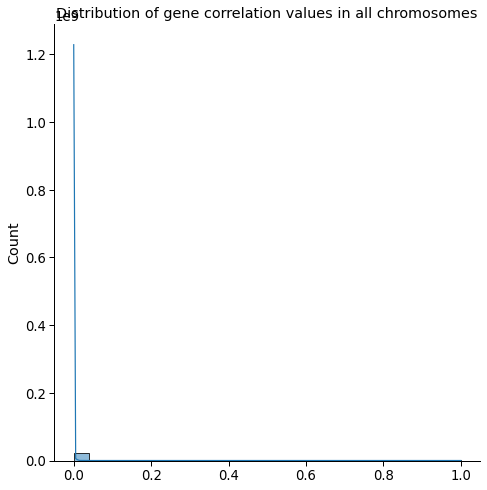

In [65]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

### Plot: heatmap

In [66]:
vmin_val = 0.0
vmax_val = max(0.05, _corr_mat.quantile(0.99))
display(f"{vmin_val} / {vmax_val}")

'0.0 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

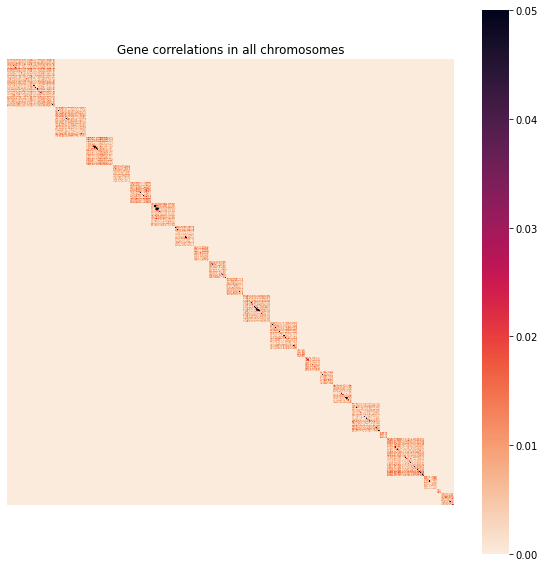

In [67]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="rocket_r",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

## On nonzero correlations

In [68]:
nonzero_corrs = full_corr_matrix_flat[full_corr_matrix_flat > 0.0]

In [69]:
_corr_mat = nonzero_corrs

In [70]:
_corr_mat.shape

(1175424,)

In [71]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.120590
ENSG00000187608  ENSG00000188976    0.177063
                 ENSG00000188290    0.672060
ENSG00000188157  ENSG00000188976    0.085746
                 ENSG00000188290    0.391127
dtype: float64

In [72]:
_corr_mat.describe().apply(str)

count                1175424.0
mean       0.00812056409060158
std        0.02878972160919992
min      1.772569924300621e-10
25%       0.003610011770910453
50%       0.005611477737393171
75%       0.007924554806352813
max         0.9999900000499999
dtype: object

In [73]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    1.772570e-10
0.05    1.376817e-03
0.10    2.103061e-03
0.15    2.673603e-03
0.20    3.164142e-03
0.25    3.610012e-03
0.30    4.028999e-03
0.35    4.431617e-03
0.40    4.825607e-03
0.45    5.219056e-03
0.50    5.611478e-03
0.55    6.020045e-03
0.60    6.441637e-03
0.65    6.893464e-03
0.70    7.383680e-03
0.75    7.924555e-03
0.80    8.548471e-03
0.85    9.313649e-03
0.90    1.034614e-02
0.95    1.213213e-02
dtype: float64

In [74]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    1.772570e-10
0.0001    1.089498e-06
0.0002    3.299784e-06
0.0003    6.496161e-06
0.0004    1.028796e-05
0.0005    1.460692e-05
0.0006    1.871180e-05
0.0007    2.344684e-05
0.0008    2.887152e-05
0.0009    3.387836e-05
dtype: float64

In [75]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.503479
0.9991    0.521125
0.9992    0.542781
0.9993    0.565972
0.9994    0.587782
0.9995    0.614514
0.9996    0.645528
0.9997    0.678799
0.9998    0.725961
0.9999    0.804971
1.0000    0.999990
dtype: float64

### Plot: distribution

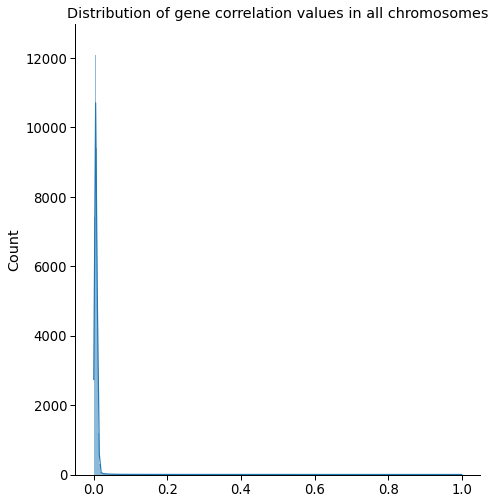

In [76]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

# Save

## With ensemble ids

## With gene symbols

In [77]:
output_file = OUTPUT_DIR_BASE / "gene_corrs-symbols.pkl"
display(output_file)

PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/1000g_eur/gtex_v8/mashr/gene_corrs-symbols.pkl')

In [78]:
gene_corrs = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [79]:
assert not gene_corrs.isna().any(None)
assert not np.isinf(gene_corrs.to_numpy()).any()
assert not np.iscomplex(gene_corrs.to_numpy()).any()

In [80]:
assert gene_corrs.index.is_unique
assert gene_corrs.columns.is_unique

In [81]:
gene_corrs.shape

(6442, 6442)

In [82]:
gene_corrs.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.120590,0.177063,0.085746,0.006792,0.007685,0.004673,0.010734,0.011200,0.007529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.120590,1.000000,0.672060,0.391127,0.011695,0.009275,0.005970,0.007385,0.002641,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.177063,0.672060,1.000000,0.424696,0.013929,0.013311,0.008466,0.010608,0.006689,0.011659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.085746,0.391127,0.424696,1.000000,0.005309,0.011848,0.002161,0.002535,0.005359,0.007012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.006792,0.011695,0.013929,0.005309,1.000000,0.338085,0.550817,0.154394,0.193627,0.101004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
gene_corrs.to_pickle(output_file)